In [1]:
# our commonly used functions
from global_bug_bot_functions import  *


# libraries for building convolutional neural network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model

# libraries for tuning models
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperParameters
from tensorflow.keras import backend as K
from keras.callbacks import History, EarlyStopping
from tensorflow.keras.regularizers import l2


# utility libraries
import os
import time
import itertools
import random
import numpy as np

# Force TensorFlow to use GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')  # Use only the first GPU
        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found, using CPU.")

# Set random seeds for reproducibility
seed_value = 2025
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# data set constants
TRAIN_GENERATOR = load_data(TRAIN_DIR)
VAL_GENERATOR = load_data(VALID_DIR)
TEST_GENERATOR = load_data(TEST_DIR, shuffle_flag=False)
EVAL_VAL_GENERATOR = load_data(VALID_DIR, shuffle_flag=False)

# best hps found from tuning
# from ep20_pat3_del0.001_ex1_maxtr20_from_tuning_script_final_tuned_models_results_DenseNet201.csv
# ---> tuned with max epoch = 20, patience = 3, minimum delta = 0.001, max trials = 20
best_lr = 0.001
best_dropout = 0.3
best_batch_size	= 16
best_epochs	= 15


with tf.device('/GPU:0'):
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # freeze the base model layers
    base_model.trainable = False
    
    # global pooling and dropout layers included similar to jute pest architecture
    x = BatchNormalization()(base_model.output) # JUST ADDED
    x = Dropout(best_dropout)(x) # JUST ADDED
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = Dropout(best_dropout)(x)
    x = BatchNormalization()(x) # JUST ADDED
    
    # final softmax probabilistic classification layer - JUST ADDED L2
    output_layer = Dense(TRAIN_GENERATOR.num_classes, activation='softmax', kernel_regularizer=l2(0.05))(x)
    model = Model(inputs=base_model.input, outputs=output_layer)
    
    optimizer = Adam(learning_rate=best_lr)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(TRAIN_GENERATOR,validation_data=VAL_GENERATOR, epochs = best_epochs, batch_size = best_batch_size)



Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Found 6108 images belonging to 11 classes.
Found 440 images belonging to 11 classes.
Found 220 images belonging to 11 classes.
Found 440 images belonging to 11 classes.
Epoch 1/15
191/191 [==============================] - 36s 112ms/step - loss: 1.6683 - accuracy: 0.6601 - val_loss: 1.4341 - val_accuracy: 0.6614
Epoch 2/15
191/191 [==============================] - 18s 94ms/step - loss: 0.9281 - accuracy: 0.8369 - val_loss: 1.2000 - val_accuracy: 0.7250
Epoch 3/15
191/191 [==============================] - 18s 94ms/step - loss: 0.8149 - accuracy: 0.8659 - val_loss: 1.1258 - val_accuracy: 0.7523
Epoch 4/15
191/191 [==============================] - 18s 96ms/step - loss: 0.7858 - accuracy: 0.8710 - val_loss: 1.0949 - val_accuracy: 0.7409
Epoch 5/15
191/191 [==============================] - 19s 101ms/step - loss: 0.7691 - accuracy: 0.8710 - val_loss: 1.1018 - val_accuracy: 0.7386
Epoch 6/15
191/191 [=============

# Validation plots

14/14 [==============================] - 5s 98ms/step
Classification Report:


,precision,recall,f1-score,support
adult_rice_weevil,0.717949,0.700,0.708861,40.000
american_house_spider,0.864865,0.800,0.831169,40.000
bedbug,0.666667,0.600,0.631579,40.000
brown_stink_bug,0.682927,0.700,0.691358,40.000
carpenter_ant,0.714286,0.750,0.731707,40.000
cellar_spider,0.875000,0.875,0.875000,40.000
flea,0.500000,0.600,0.545455,40.000
house_centipede,1.000000,0.800,0.888889,40.000
silverfish,0.756098,0.775,0.765432,40.000
subterranean_termite,0.575000,0.575,0.575000,40.000


<Figure size 800x600 with 0 Axes>

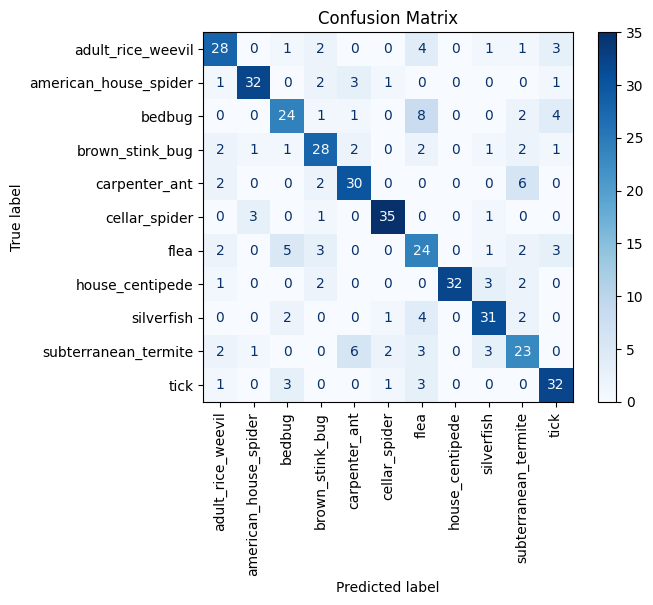

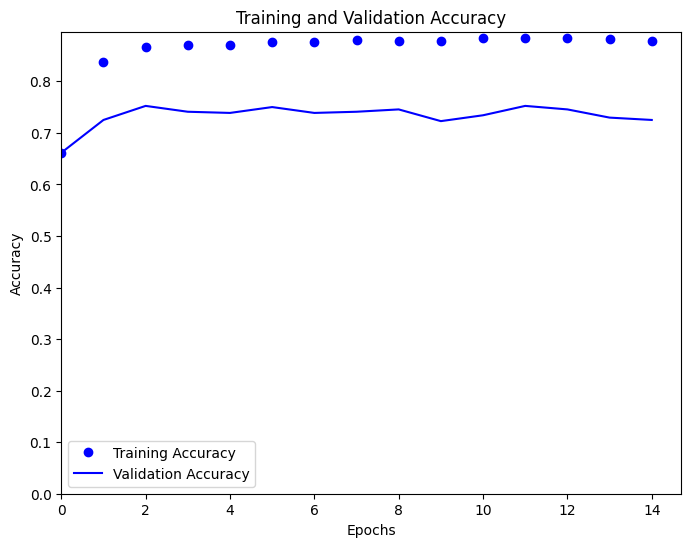

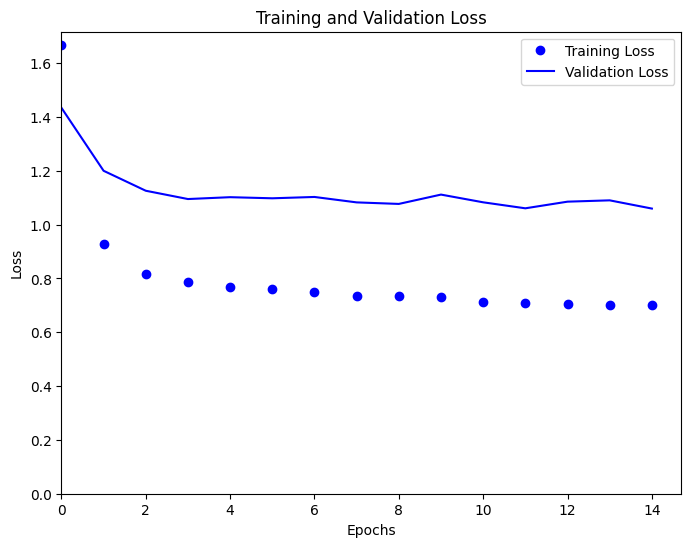

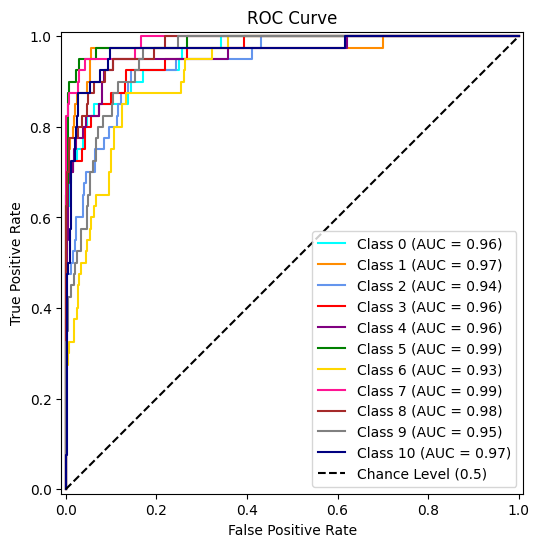

Macro-averaged One-vs-One ROC AUC score: 0.96
Accuracy: 0.725
Precision: 0.735
Recall: 0.725
F1 Score: 0.728


{'accuracy': 0.725,
 'precision': 0.735,
 'recall': 0.725,
 'f1_score': 0.728,
 'classification_report_df':                        precision  recall  f1-score  support
 adult_rice_weevil       0.717949   0.700  0.708861   40.000
 american_house_spider   0.864865   0.800  0.831169   40.000
 bedbug                  0.666667   0.600  0.631579   40.000
 brown_stink_bug         0.682927   0.700  0.691358   40.000
 carpenter_ant           0.714286   0.750  0.731707   40.000
 cellar_spider           0.875000   0.875  0.875000   40.000
 flea                    0.500000   0.600  0.545455   40.000
 house_centipede         1.000000   0.800  0.888889   40.000
 silverfish              0.756098   0.775  0.765432   40.000
 subterranean_termite    0.575000   0.575  0.575000   40.000
 tick                    0.727273   0.800  0.761905   40.000
 accuracy                0.725000   0.725  0.725000    0.725
 macro avg               0.734551   0.725  0.727850  440.000
 weighted avg            0.734551   0.7

In [2]:
%matplotlib inline
evaluation_metrics(model, EVAL_VAL_GENERATOR, history)


# Validation metrics: 'accuracy': 0.725,'precision': 0.735,'recall': 0.725,'f1_score': 0.728

# Test plots

7/7 [==============================] - 1s 79ms/step
Classification Report:


,precision,recall,f1-score,support
adult_rice_weevil,0.882353,0.750000,0.810811,20.000000
american_house_spider,0.894737,0.850000,0.871795,20.000000
bedbug,0.761905,0.800000,0.780488,20.000000
brown_stink_bug,0.900000,0.900000,0.900000,20.000000
carpenter_ant,0.727273,0.800000,0.761905,20.000000
cellar_spider,0.750000,0.900000,0.818182,20.000000
flea,0.538462,0.700000,0.608696,20.000000
house_centipede,1.000000,0.700000,0.823529,20.000000
silverfish,0.833333,0.750000,0.789474,20.000000
subterranean_termite,0.619048,0.650000,0.634146,20.000000


<Figure size 800x600 with 0 Axes>

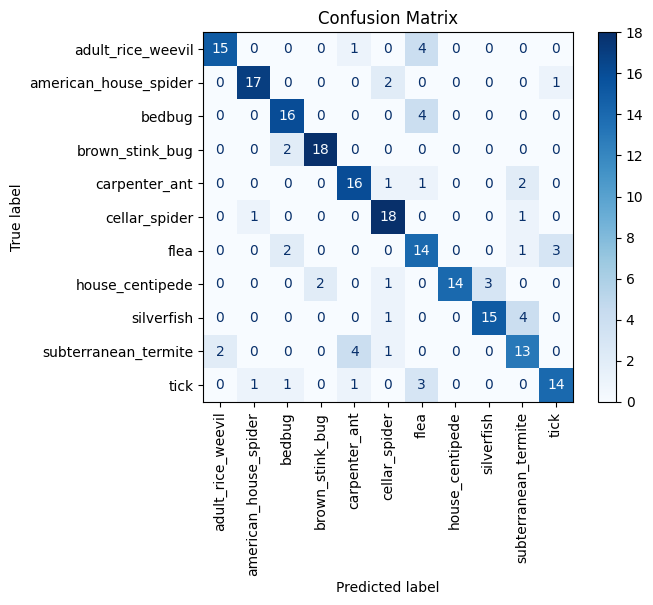

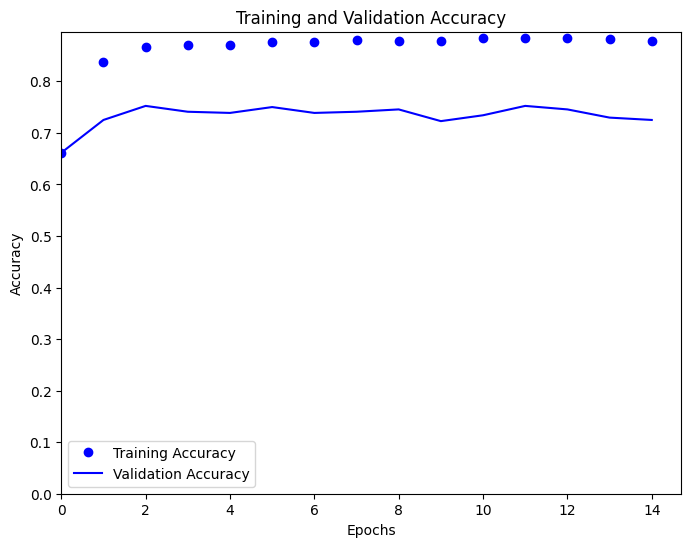

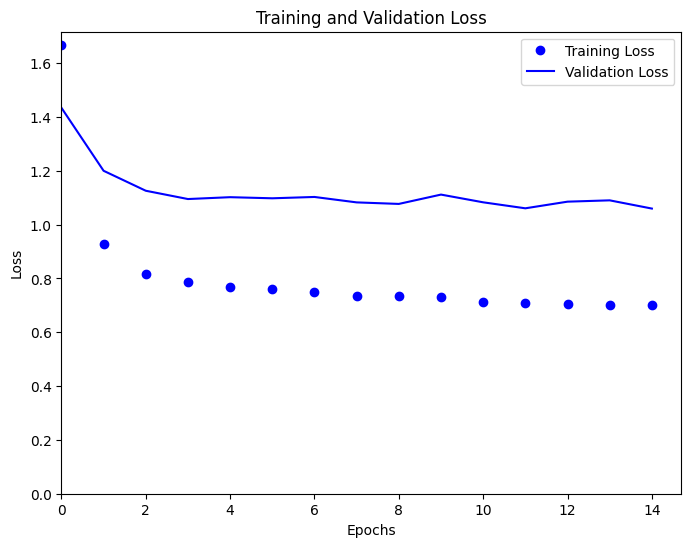

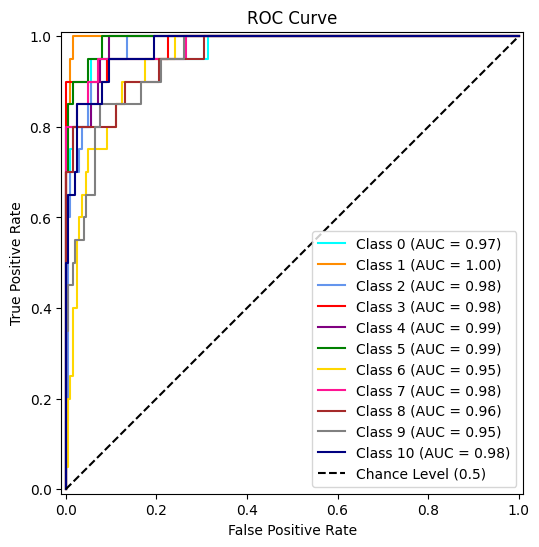

Macro-averaged One-vs-One ROC AUC score: 0.97
Accuracy: 0.773
Precision: 0.79
Recall: 0.773
F1 Score: 0.776


{'accuracy': 0.773,
 'precision': 0.79,
 'recall': 0.773,
 'f1_score': 0.776,
 'classification_report_df':                        precision    recall  f1-score     support
 adult_rice_weevil       0.882353  0.750000  0.810811   20.000000
 american_house_spider   0.894737  0.850000  0.871795   20.000000
 bedbug                  0.761905  0.800000  0.780488   20.000000
 brown_stink_bug         0.900000  0.900000  0.900000   20.000000
 carpenter_ant           0.727273  0.800000  0.761905   20.000000
 cellar_spider           0.750000  0.900000  0.818182   20.000000
 flea                    0.538462  0.700000  0.608696   20.000000
 house_centipede         1.000000  0.700000  0.823529   20.000000
 silverfish              0.833333  0.750000  0.789474   20.000000
 subterranean_termite    0.619048  0.650000  0.634146   20.000000
 tick                    0.777778  0.700000  0.736842   20.000000
 accuracy                0.772727  0.772727  0.772727    0.772727
 macro avg               0.789535  0

In [3]:
%matplotlib inline
evaluation_metrics(model, TEST_GENERATOR, history)


# Test metrics: 'accuracy': 0.773, 'precision': 0.79,'recall': 0.773, 'f1_score': 0.776